In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [104]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


## Define the cases

In [105]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test042"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d0911/Measure_MAT/Test042_E_d50_R_H150_T100_R01.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'ConversionOffset', 'DefaultData', 'MP3Filtered', 'MP3RawValue', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test042
   - testType: E
   - repeatType: R1
   - useTest: nan
   - fSampling: 50.0
   - calibrationFile: Test042
   - depthAtWM: 0.503
   - depthAtMPL: 0.47
   - waveType: Regular
   - waveAmplitude: 0.15
   - wavePeriod: 1.0
   - focusingLocation: nan
   - remarks: nan
=== End of Test Properties ===



In [106]:
testName2 = "Test324"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1008/Measure_MAT/Test324_M_d50_R_H150_T100_R02.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test324
   - testType: MPL
   - repeatType: R2
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.506
   - depthAtMPL: 0.473
   - waveType: Regular
   - waveAmplitude: 0.15
   - wavePeriod: 1.0
   - focusingLocation: nan
   - remarks: Empty = Test042, GP1, GP2, GP3
=== End of Test Properties ===



In [107]:
testName_peaks = 'Test324'

## Extract Default Dataset and Set Tare

In [108]:
ds1 = loaded_mat1["DefaultData"]
fSampling1 = loaded_mat1["TestProperties"]['fSampling']
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
fSampling2 = loaded_mat2["TestProperties"]['fSampling']
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 2
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3RawValue'}
{'reference': 'MP3Filtered'}


## Shift time coord to overlap signals

### Based on max-value

In [109]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

### Based on cross-correlation

In [110]:
def sync_signals_crosscorr(ds1, fSampling1, ds2, fSampling2, tmin, tmax, wg='WG01'):
    """Sync the signals using cross-correlation for the given wave gauge."""
    
    ds1_cut = ds1[wg].sel(Time=slice(tmin, tmax))
    ds2_cut = ds2[wg].sel(Time=slice(tmin, tmax))

    # time_lag = skb.postprocess.sync_signals_crosscorr_downsample(
    time_lag_maxCorr, time_lag_mat = skb.postprocess.sync_signals_crosscorr_upsample(
        ds1_cut, fSampling1, 
        ds2_cut, fSampling2, plotflag=True
    )

    return time_lag_maxCorr, time_lag_mat

Peaks in cross-corr: [-5.15820312 -4.16015625 -3.15917969 -2.15673828 -1.15332031 -0.14941406
  0.85253906]


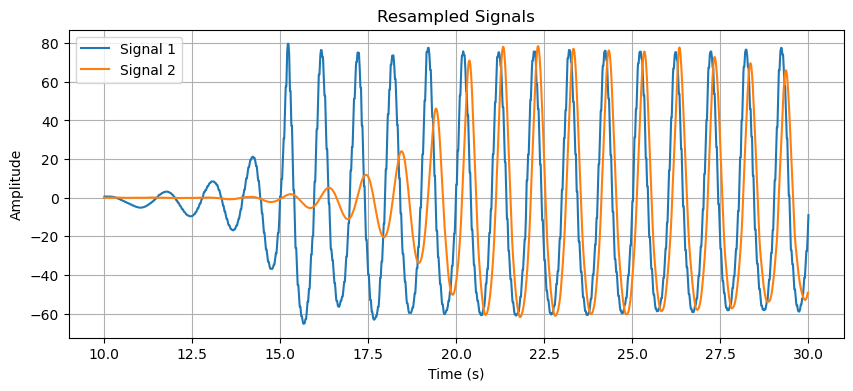

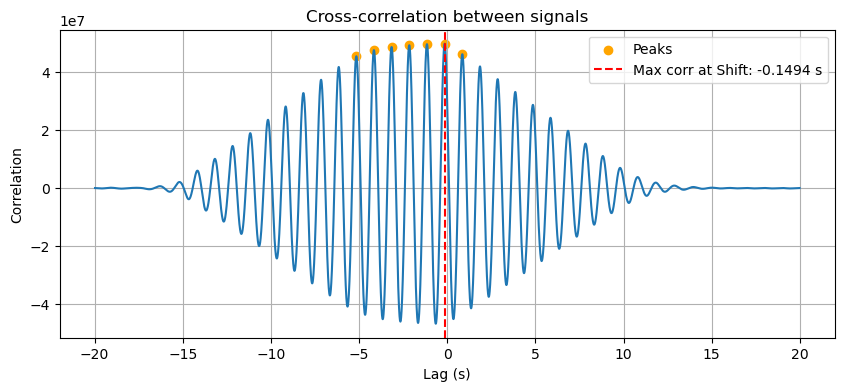

Shifting ds2 by -3.1591796875


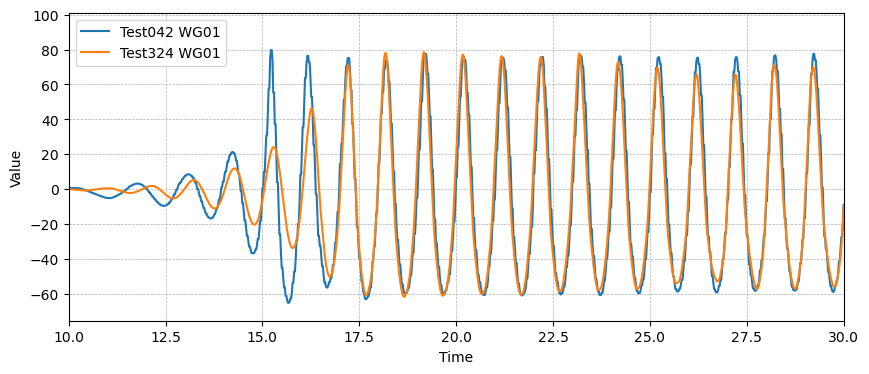

In [111]:
# # Shift ds2 time to align max of WG01
# # Can change to any other probe as needed

# # Using max-value
# ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=0, tmax=22)
# tShift = ds1_max_idxtime['WG01'].values - ds2_max_idxtime['WG01'].values

# Using cross-correlation
tShift_maxCorr, tShift_array = sync_signals_crosscorr(
    ds1, fSampling1, ds2, fSampling2, 
    tmin=10, tmax=30, wg = 'WG01' )
# tShift = tShift_maxCorr
tShift = tShift_array[2]

ds2 = ds2.assign_coords(Time=ds2['Time'] + tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

# Post shifting comparison plots
tmin = 10
tmax = 30

fig, ax = plt.subplots(figsize=(10,4))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.set_xlim(tmin, tmax)
set_min_plot_prop(ax)
plt.show()


## Get LED on off indices

In [112]:
skb.postprocess.update_LED_transition_indices(ds1)
skb.postprocess.update_LED_transition_indices(ds2)

print("DS1 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds1.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds1.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds1.attrs["LED_time_1_to_0"] - ds1.attrs["LED_time_0_to_1"]:.4f}')

print("\nDS2 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds2.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds2.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds2.attrs["LED_time_1_to_0"] - ds2.attrs["LED_time_0_to_1"]:.4f}')

No LED transitions found in 'LED-chan100' data.
DS1 LED Transition Indices:
LED_time_0_to_1 = 0.0000
LED_time_1_to_0 = 0.0000
dt = 0.0000

DS2 LED Transition Indices:
LED_time_0_to_1 = 4.9668
LED_time_1_to_0 = 11.2168
dt = 6.2500


## Load peaks

In [113]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/AllTest_log"
peaks_file_name = "log_videos_peak_regular.xlsx"

peaks_file = pd.ExcelFile(f"{data_folder}/{peaks_file_name}")
df = pd.read_excel(peaks_file, sheet_name='Sheet1')

# pprint(df.head())

In [114]:
testpeaks = df[df['Test_ID'] == testName_peaks]
# print(testpeaks)

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
pprint(testpeaks_LED_on); print()

tShift_peaks = ds2.attrs["LED_time_0_to_1"] - testpeaks_LED_on.values[0]
pprint(f"Shifting video peaks by {tShift_peaks}"); print()

flumeBottom_to_MPLBottom = 3 #mm
depthAtMPL = loaded_mat2['TestProperties']['depthAtMPL'] 

pprint(testpeaks.head()); print()
testpeaks.loc[:,'time_s'] = testpeaks['time_s'] + tShift_peaks

pprint(testpeaks.head()); print()

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
testpeaks_LED_off = testpeaks[testpeaks['event_type']=='LED_off']['time_s']
testpeaks_peaks = testpeaks[testpeaks['event_type'] == 'peak']
testpeaks_peaks.loc[:, 'value'] = testpeaks_peaks['value'] - depthAtMPL*1000 + flumeBottom_to_MPLBottom


pprint(testpeaks_peaks.head())

75    9.026
Name: time_s, dtype: float64

'Shifting video peaks by -4.0591996875'

    Test_ID event_type  event_id  time_s  value
75  Test324     LED_on       1.0   9.026      1
76  Test324    LED_off       1.0  15.299      0
77  Test324       peak       1.0  24.358    565
78  Test324       peak       2.0  25.259    620
79  Test324       peak       3.0  26.243    600

    Test_ID event_type  event_id   time_s  value
75  Test324     LED_on       1.0   4.9668      1
76  Test324    LED_off       1.0  11.2398      0
77  Test324       peak       1.0  20.2988    565
78  Test324       peak       2.0  21.1998    620
79  Test324       peak       3.0  22.1838    600

    Test_ID event_type  event_id   time_s  value
77  Test324       peak       1.0  20.2988     95
78  Test324       peak       2.0  21.1998    150
79  Test324       peak       3.0  22.1838    130
80  Test324       peak       4.0  23.1848    120
81  Test324       peak       5.0  24.2188    115


## Plot signals

### WM Probe

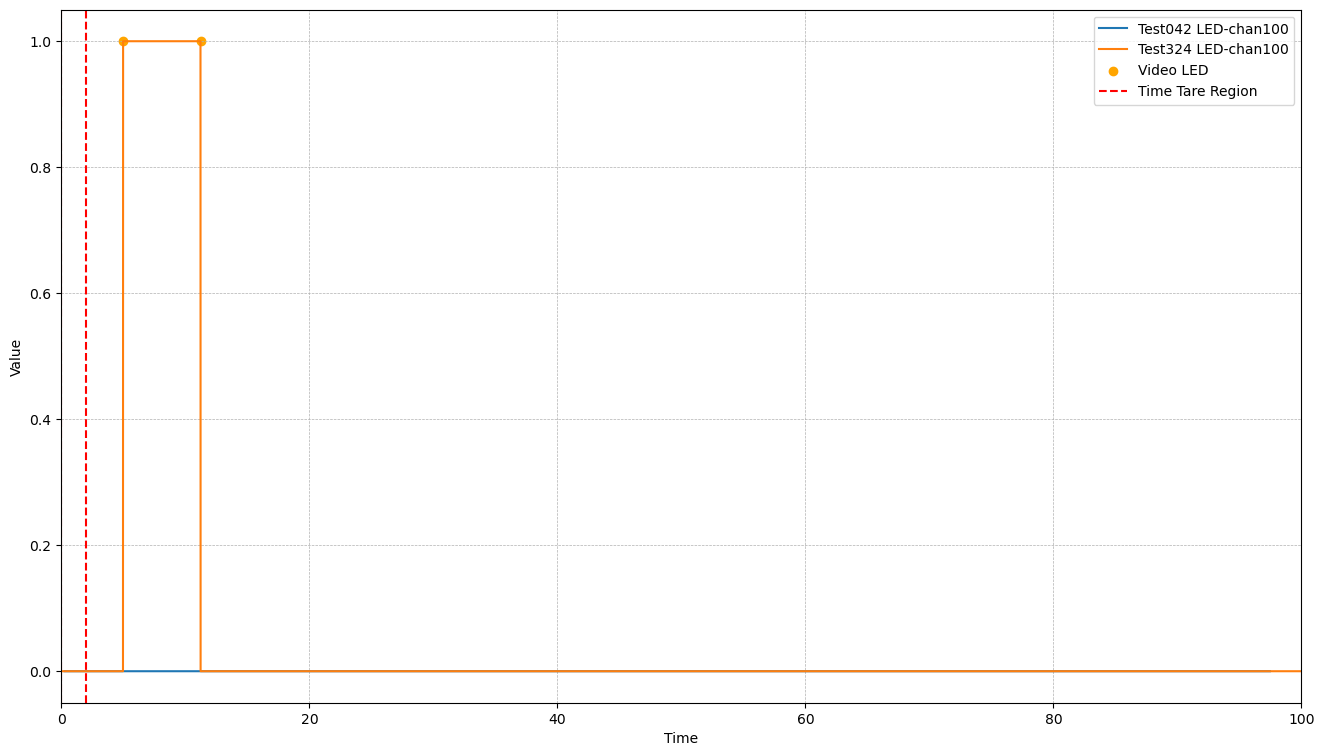

In [115]:
xmin = 0
xmax = 100


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label=f"{testName1} WM")
# ds2['WM'].plot(linestyle='-', label=f"{testName2} WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['LED-chan100'].plot(linestyle='-', label=f"{testName1} LED-chan100")
ds2['LED-chan100'].plot(linestyle='-', label=f"{testName2} LED-chan100")
plt.scatter([testpeaks_LED_on.values, testpeaks_LED_off.values], [1, 1], 
    color = 'orange',label = 'Video LED')
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

### WG01 - WG03

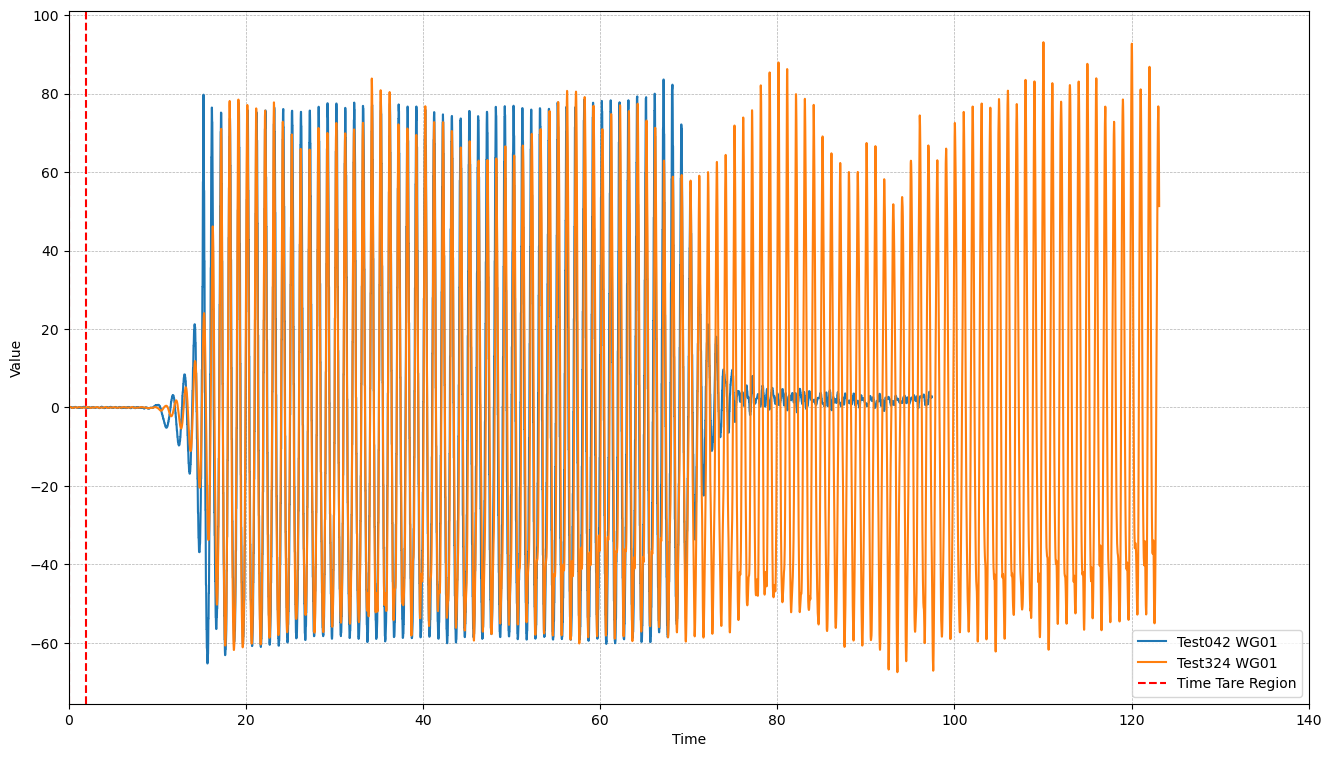

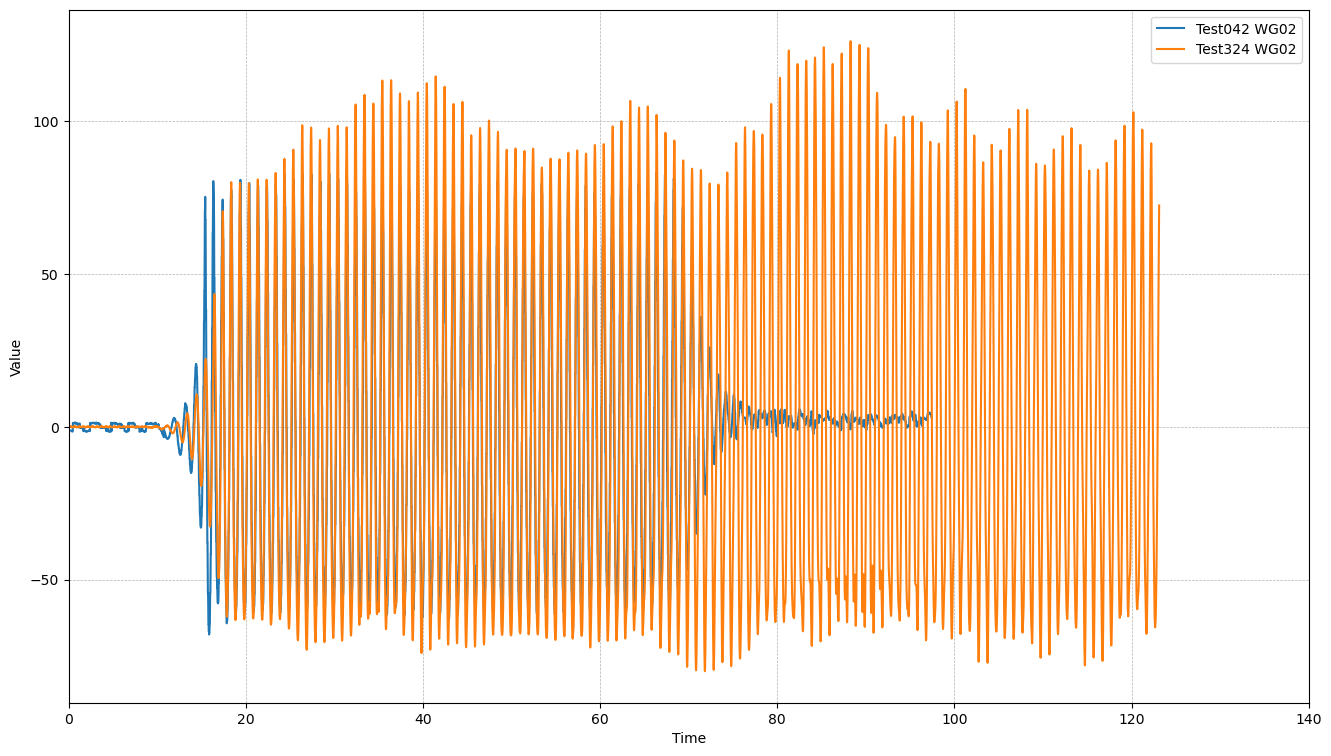

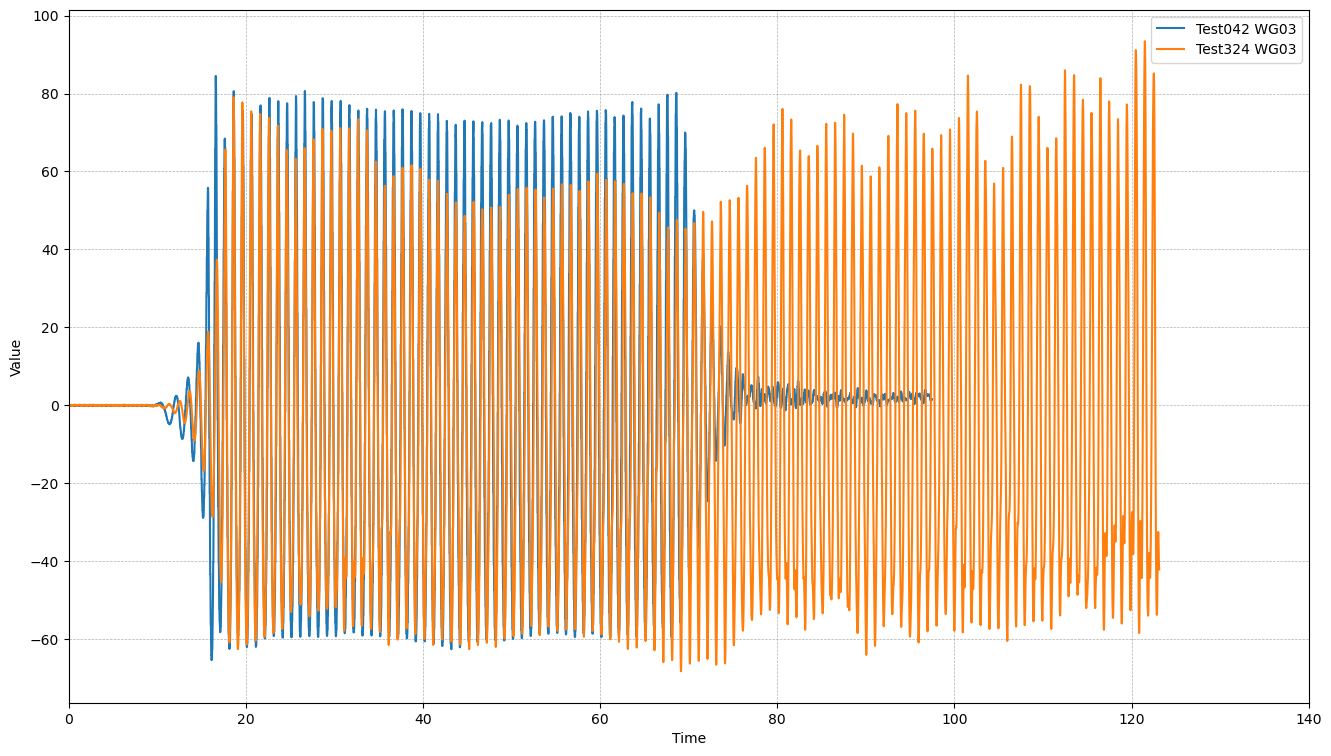

In [116]:
xmin = 0
xmax = 140

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG02'].plot(linestyle='-', label=f"{testName1} WG02")
ds2['WG02'].plot(linestyle='-', label=f"{testName2} WG02")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG03'].plot(linestyle='-', label=f"{testName1} WG03")
ds2['WG03'].plot(linestyle='-', label=f"{testName2} WG03")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG04 - WG06

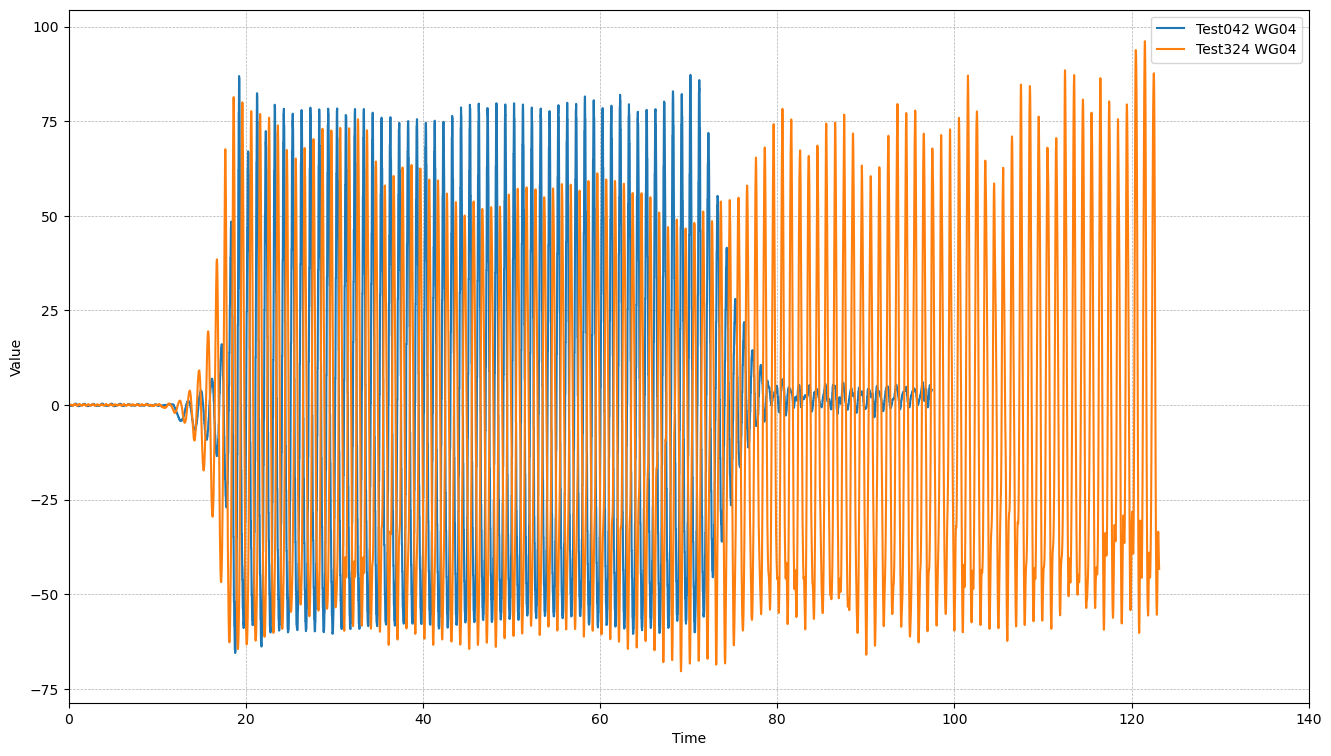

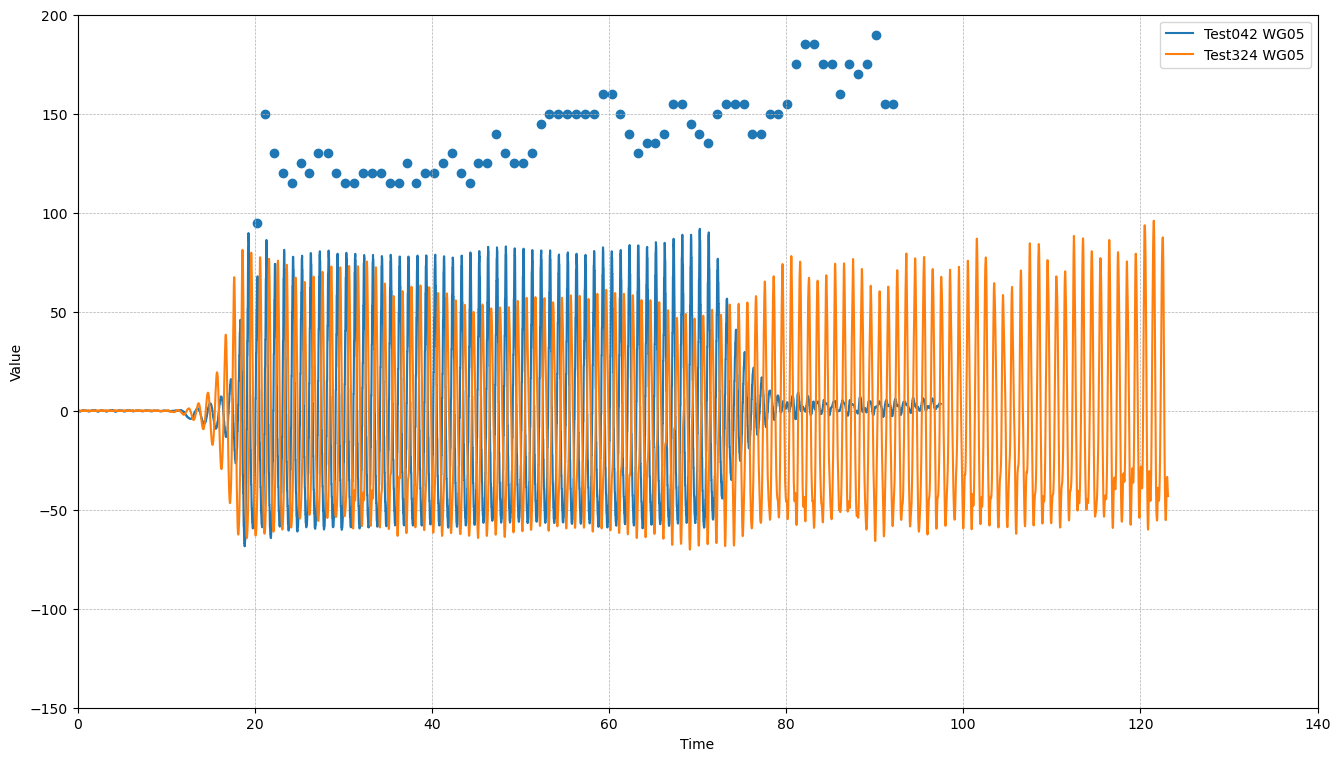

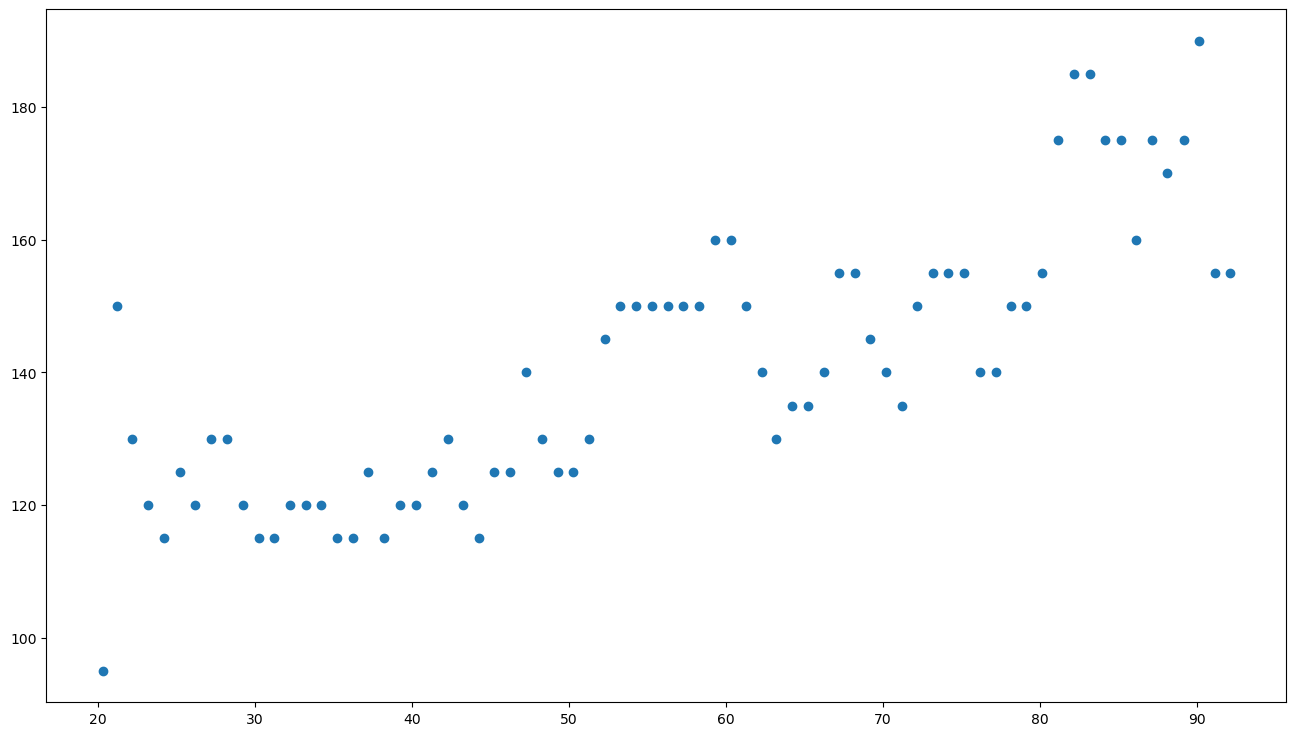

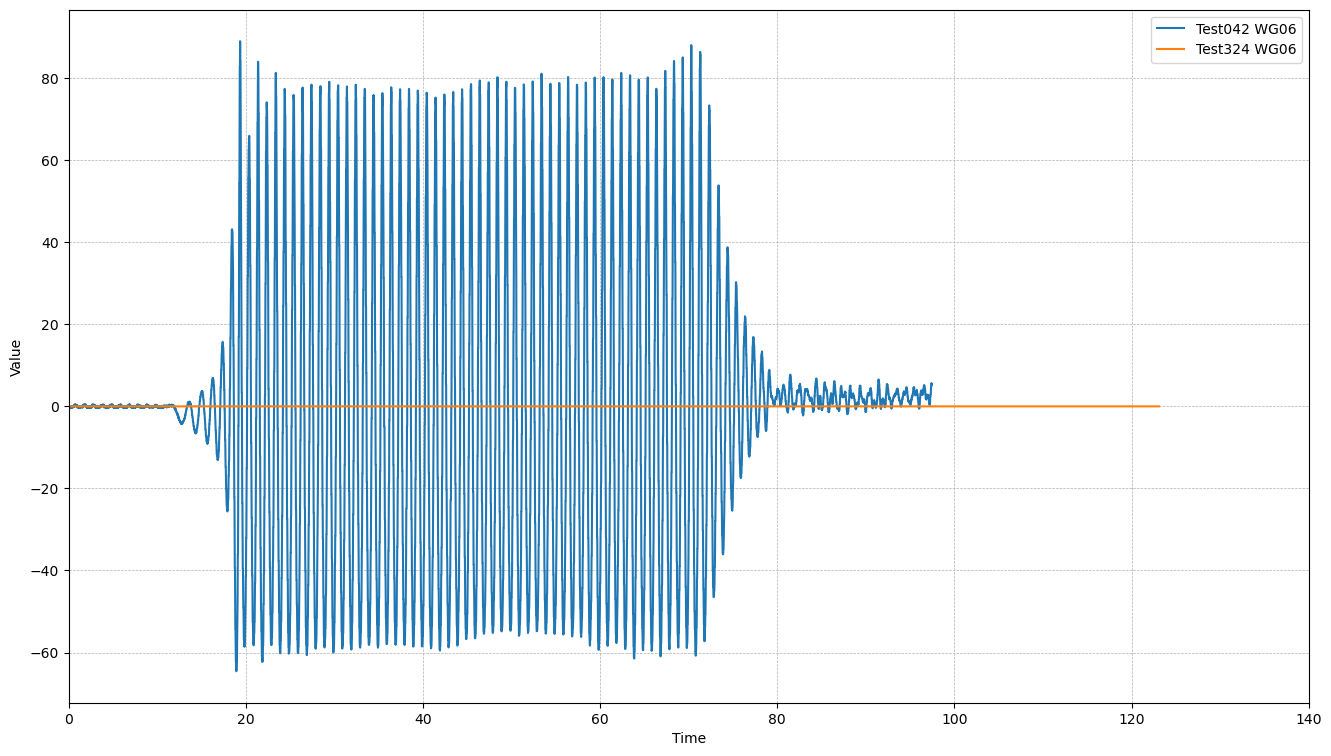

In [123]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG04'].plot(linestyle='-', label=f"{testName1} WG04")
ds2['WG04'].plot(linestyle='-', label=f"{testName2} WG04")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG05'].plot(linestyle='-', label=f"{testName1} WG05")
ds2['WG05'].plot(linestyle='-', label=f"{testName2} WG05")
plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'])
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
plt.ylim(-150, 200)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'])
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG06'].plot(linestyle='-', label=f"{testName1} WG06")
ds2['WG06'].plot(linestyle='-', label=f"{testName2} WG06")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG07 - WG09

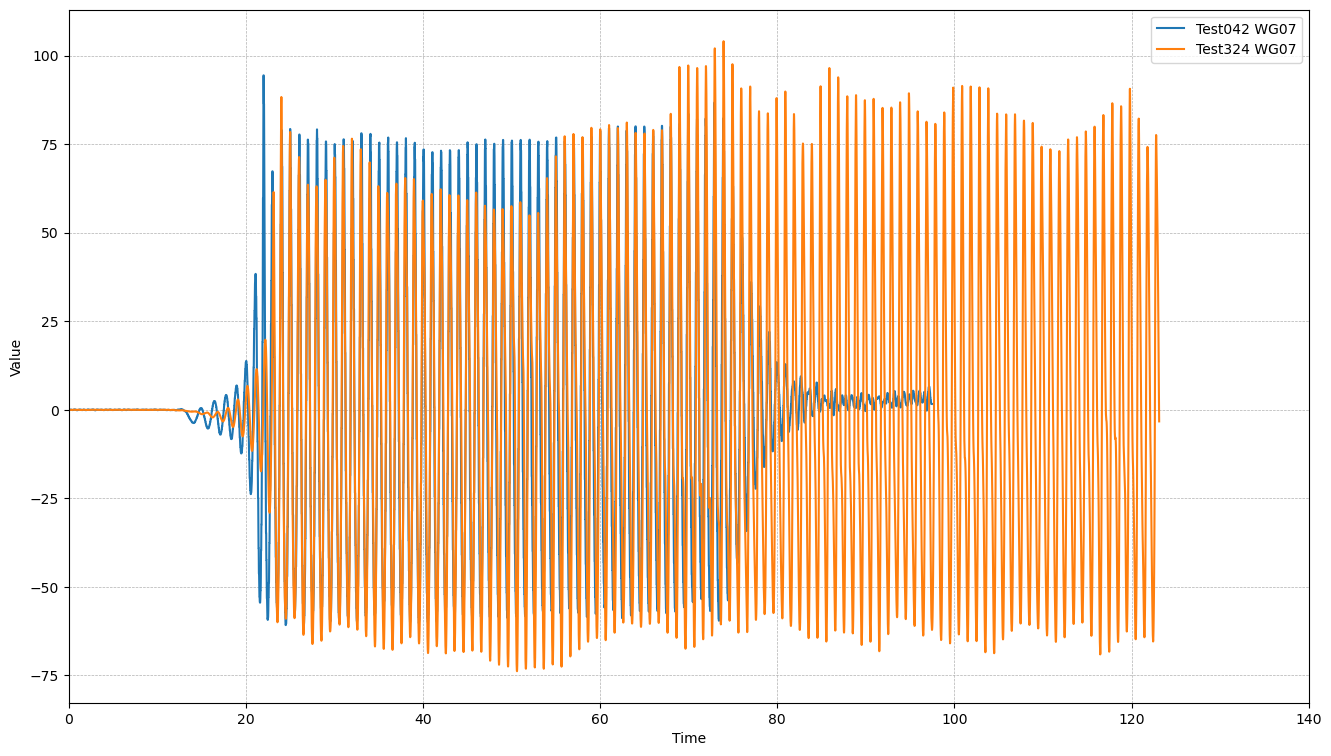

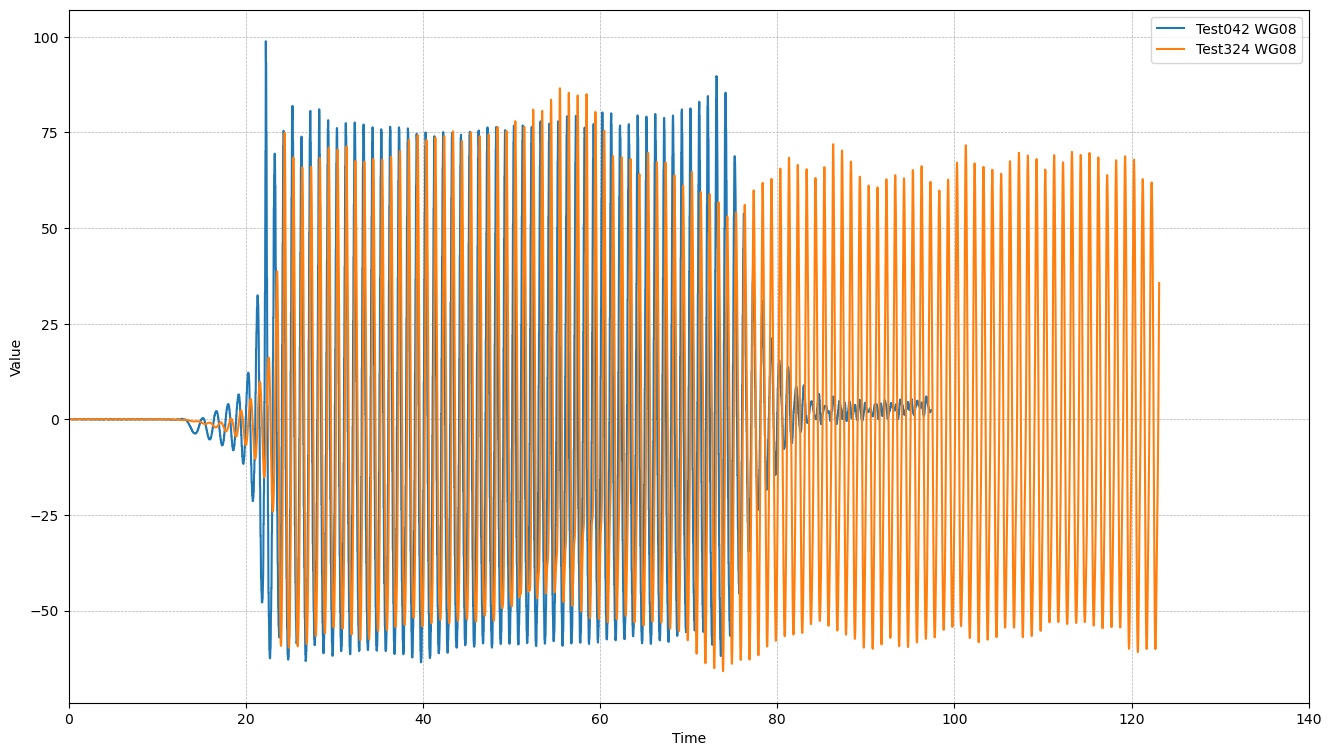

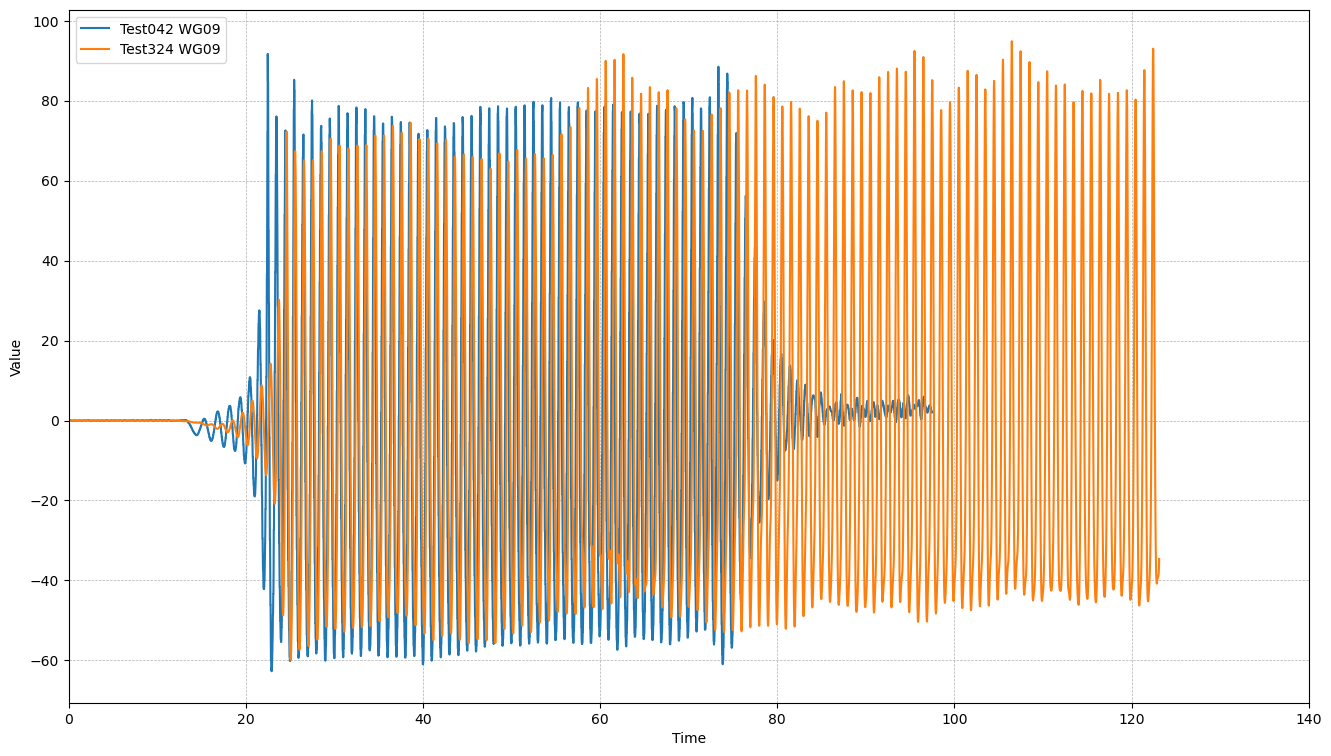

In [118]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG07'].plot(linestyle='-', label=f"{testName1} WG07")
ds2['WG07'].plot(linestyle='-', label=f"{testName2} WG07")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG08'].plot(linestyle='-', label=f"{testName1} WG08")
ds2['WG08'].plot(linestyle='-', label=f"{testName2} WG08")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG09'].plot(linestyle='-', label=f"{testName1} WG09")
ds2['WG09'].plot(linestyle='-', label=f"{testName2} WG09")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

## Find maxima

In [119]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [120]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

print("DS1 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut)
print()

print("DS2 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut)  

DS1 Signal Min/Max in selected time range:
Signal: WG01   Max Value: 83.61337159090907 at :  67.1596   Min Value: -65.25412840909092 at :  15.6596
Signal: WG02   Max Value: 83.10538295454542 at :  66.3396   Min Value: -67.95361704545459 at :  15.8596
Signal: WG03   Max Value: 84.49570340909092 at :  16.5996   Min Value: -65.36689659090909 at :  16.1396
Signal: WG04   Max Value: 87.24166499999995 at :  70.1996   Min Value: -65.56067500000005 at :  18.7996
Signal: WG05   Max Value: 91.87708068181819 at :  70.2596   Min Value: -68.46626931818182 at :  18.8596
Signal: WG06   Max Value: 88.99149659090908 at :  19.3596   Min Value: -64.55210340909092 at :  18.9196
Signal: WG07   Max Value: 94.41302272727272 at :  21.9996   Min Value: -60.89772727272728 at :  26.5396
Signal: WG08   Max Value: 98.86582477272728 at :  22.2596   Min Value: -63.52498522727272 at :  39.7796
Signal: WG09   Max Value: 91.70584704545456 at :  22.4796   Min Value: -62.718182954545426 at :  22.9196
Signal: LED-chan100 

## Plot Spec

In [121]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 1500
Least count Hz = 0.03333333333333333
Max Freq (Half band) Hz = 25.0
Sample Len = 61440
Least count Hz = 0.03333333333333333
Max Freq (Half band) Hz = 1024.0


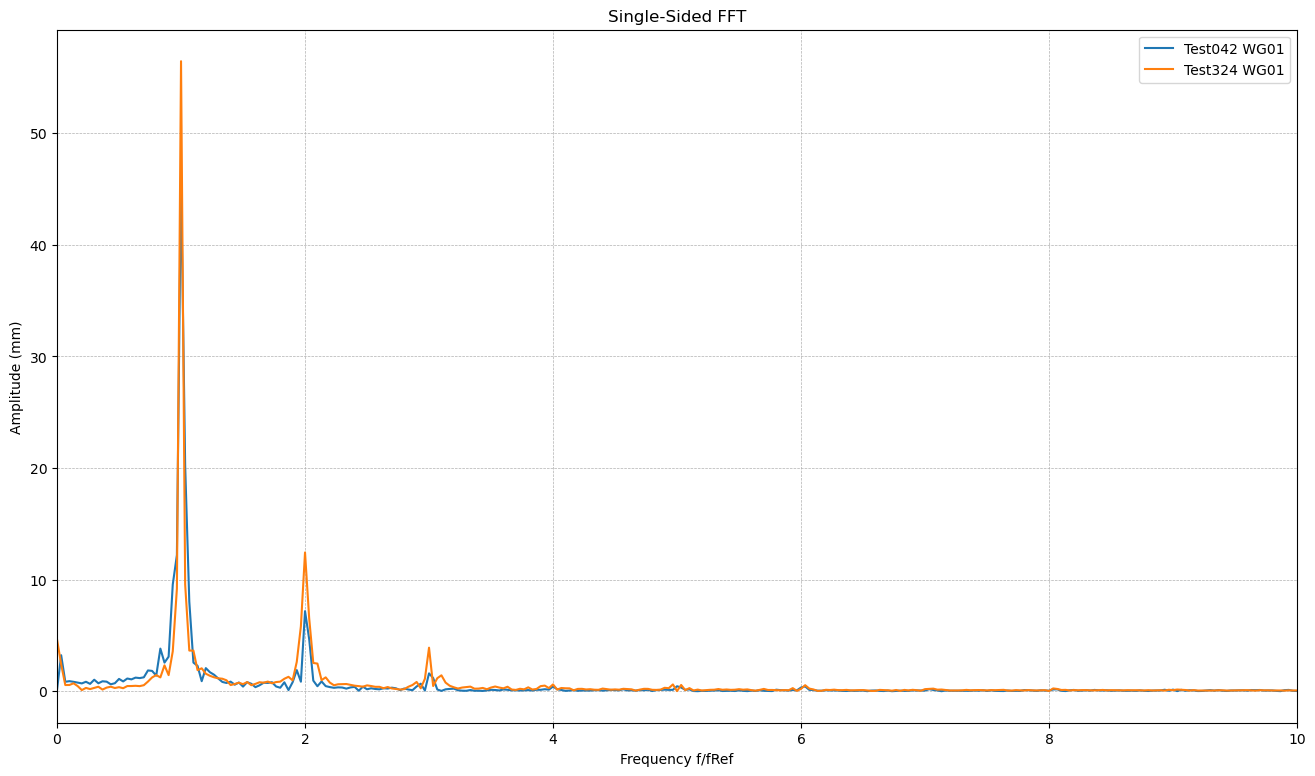

In [122]:
tmin = 50
tmax = 80

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

fSampling1 = loaded_mat1['TestProperties']['fSampling']
fSampling2 = loaded_mat2['TestProperties']['fSampling']

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, f"{testName1} WG01")
# getSpec(ds1_cut['WG05'], fSampling1, ax, xlim, f"{testName1} WG05")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, f"{testName1} WG07")
getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, f"{testName2} WG01")

pass